57/57 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0801 - loss: 3.0203 - val_accuracy: 0.1722 - val_loss: 2.7204
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1261 - loss: 2.6812 - val_accuracy: 0.1750 - val_loss: 2.5445
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1559 - loss: 2.5146 - val_accuracy: 0.2111 - val_loss: 2.4866
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1766 - loss: 2.4098 - val_accuracy: 0.2111 - val_loss: 2.3524
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2063 - loss: 2.3378 - val_accuracy: 0.2250 - val_loss: 2.3788
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2460 - loss: 2.2723 - val_accuracy: 0.2583 - val_loss: 2.2414
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2555 - loss: 2.1616 - val_accuracy: 0.2500 - val_loss: 2.2433
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2681 -

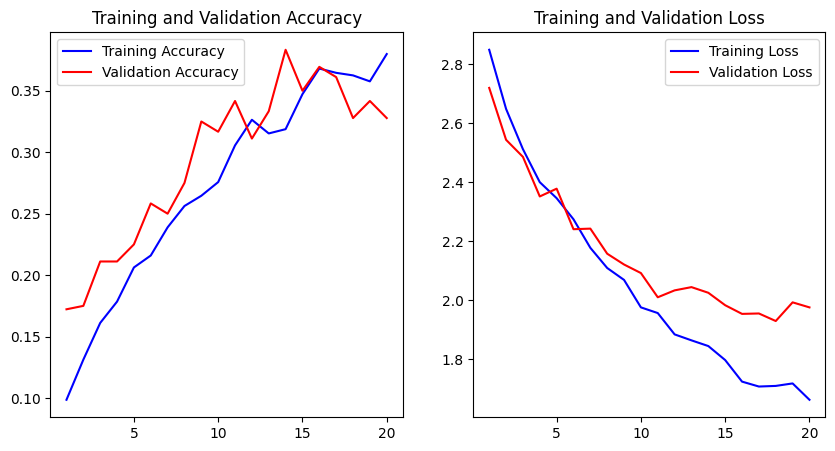

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive

def load_data_from_folder(folder_path, image_size):
    """Loads images and labels from a folder containing subdirectories for each class."""
    data = []
    labels = []
    classes = []

    for idx, class_dir in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_dir)
        if os.path.isdir(class_path):
            classes.append(class_dir)
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels)
    return data, labels, classes

def extract_features(model, data):
    """Extracts features using a pre-trained model."""
    features = model.predict(data, batch_size=32, verbose=1)
    return features

def create_generators(data, labels, batch_size):
    """Creates shuffled training and validation datasets."""
    data, labels = shuffle(data, labels, random_state=42)
    split_idx = int(0.8 * len(data))

    train_data, val_data = data[:split_idx], data[split_idx:]
    train_labels, val_labels = labels[:split_idx], labels[split_idx:]

    train_generator = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size).shuffle(len(train_data))
    val_generator = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size)

    return train_generator, val_generator

def build_cnn(input_shape, num_classes):
    """Builds a CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_training_results(history):
    """Plots training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

def main():
    dataset_folder = "/content/drive/MyDrive/Celebrity Faces Dataset"

    # Set parameters
    image_size = (128, 128)
    batch_size = 32

    # Load and preprocess data
    data, labels, classes = load_data_from_folder(dataset_folder, image_size)

    feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    feature_extractor.trainable = False
    features = extract_features(feature_extractor, data)
    features = features.reshape(features.shape[0], -1)
    train_generator, val_generator = create_generators(features, labels, batch_size)
    input_shape = (features.shape[1],)
    num_classes = len(classes)
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    epochs = 20
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )

    print("Class Indices:", {i: c for i, c in enumerate(classes)})
    plot_training_results(history)

if __name__ == '__main__':
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


57/57 ━━━━━━━━━━━━━━━━━━━━ 343s 6s/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1034 - loss: 3.0834 - val_accuracy: 0.1944 - val_loss: 2.6508
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1504 - loss: 2.6479 - val_accuracy: 0.2056 - val_loss: 2.5522
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1944 - loss: 2.4813 - val_accuracy: 0.2611 - val_loss: 2.3489
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2041 - loss: 2.3624 - val_accuracy: 0.2694 - val_loss: 2.3255
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2466 - loss: 2.2559 - val_accuracy: 0.2861 - val_loss: 2.0903
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2709 - loss: 2.0994 - val_accuracy: 0.3111 - val_loss: 2.0487
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2953 - loss: 2.0245 - val_accuracy: 0.3722 - val_loss: 1.9760
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3466 - loss: 1.9038 - val_accuracy: 0.3833 - val_loss: 1.

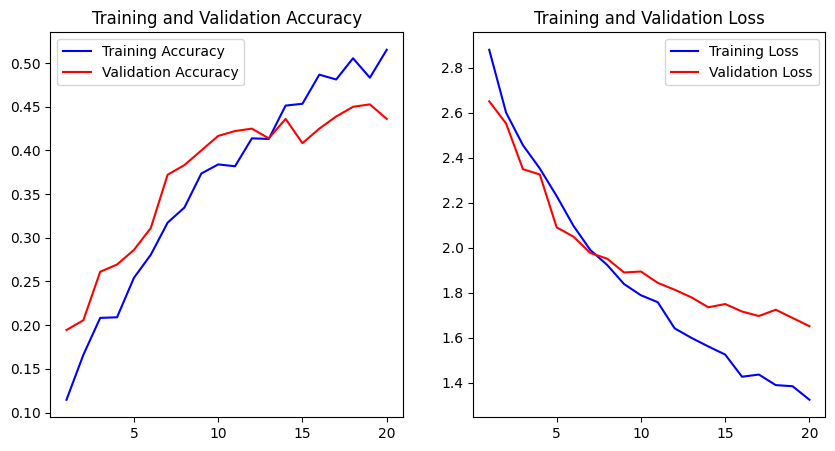

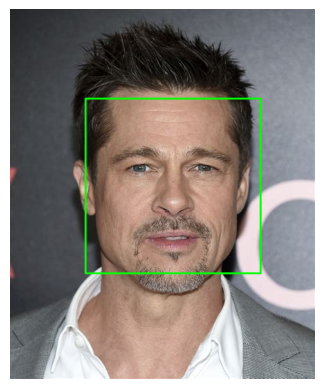

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from google.colab import drive

# Function to load images from folder
def load_data_from_folder(folder_path, image_size):
    """Loads images and labels from a folder containing subdirectories for each class."""
    data = []
    labels = []
    classes = []

    for idx, class_dir in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_dir)
        if os.path.isdir(class_path):
            classes.append(class_dir)
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels)
    return data, labels, classes

# Extract features using a pre-trained model
def extract_features(model, data):
    """Extracts features using a pre-trained model."""
    features = model.predict(data, batch_size=32, verbose=1)
    return features

# Create shuffled datasets
def create_generators(data, labels, batch_size):
    """Creates shuffled training and validation datasets."""
    data, labels = shuffle(data, labels, random_state=42)
    split_idx = int(0.8 * len(data))

    train_data, val_data = data[:split_idx], data[split_idx:]
    train_labels, val_labels = labels[:split_idx], labels[split_idx:]

    train_generator = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size).shuffle(len(train_data))
    val_generator = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size)

    return train_generator, val_generator

# Build CNN model
def build_cnn(input_shape, num_classes):
    """Builds a CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot training results
def plot_training_results(history):
    """Plots training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Detect face and draw bounding box
def detect_and_draw_face(image_path):
    """Detects face in the image and draws a bounding box around it."""
    # Load the pre-trained Haar Cascade Classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale (Haar Cascade works on grayscale images)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw bounding box around each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert image to RGB (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with the bounding box
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Main function
def main():
    dataset_folder = "/content/drive/MyDrive/Celebrity Faces Dataset"

    # Set parameters
    image_size = (128, 128)
    batch_size = 32

    # Load and preprocess data
    data, labels, classes = load_data_from_folder(dataset_folder, image_size)

    # Feature extraction with pre-trained VGG16 model
    feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    feature_extractor.trainable = False
    features = extract_features(feature_extractor, data)
    features = features.reshape(features.shape[0], -1)

    # Create training and validation generators
    train_generator, val_generator = create_generators(features, labels, batch_size)

    input_shape = (features.shape[1],)
    num_classes = len(classes)

    # Build the classification model
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    epochs = 20
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )

    # Print class indices
    print("Class Indices:", {i: c for i, c in enumerate(classes)})

    # Plot training results
    plot_training_results(history)

    sample_image_path = "/content/drive/MyDrive/Celebrity Faces Dataset/Brad Pitt/001_c04300ef.jpg"  # Modify with your image path
    detect_and_draw_face(sample_image_path)

if __name__ == '__main__':
    main()
